# Classification Algorithm Analysis
Notebook to analyze data generated by `classification_algo` in `crawler.py`.

## Setup

In [2]:
import os
import pandas as pd
import json
import statistics
from pathlib import Path
import yaml
import matplotlib.pyplot as plt
import matplotlib as mpl
from filelock import FileLock
from crawler import CrawlResults
from utils.utils import get_directories, get_domain
from utils.image_shingle import ImageShingle

##############################################################################

CRAWL_NAME = 'KJ2GW'

DATA_PATH = Path("/usr/project/xtmp/mml66/cookie-classify/") / CRAWL_NAME
ANALYSIS_PATH = Path("analysis") / CRAWL_NAME
ANALYSIS_PATH.mkdir(parents=True, exist_ok=True)

##############################################################################

with open(DATA_PATH / "config.yaml", "r") as stream:
    config = yaml.safe_load(stream)

##############################################################################

# Site list
site_list = []
with open(config["SITE_LIST_PATH"]) as file:
    for line in file:
        site_list.append(line.strip())

# Site queue
queue_lock = FileLock(config["QUEUE_PATH"] + '.lock', timeout=10)
with queue_lock:
    with open(config["QUEUE_PATH"], 'r') as file:
        site_queue = json.load(file)

# Site results
results_lock = FileLock(config["RESULTS_PATH"] + '.lock', timeout=10)
with results_lock:
    with open(config["RESULTS_PATH"]) as file:
        site_results: dict[str, CrawlResults] = json.load(file)

##############################################################################

"""
Simple sanity checks
"""
print(f"Crawled {len(site_results)}/{len(site_list)} sites.")
count = 0
our_sites = set(list(site_results.keys()) + site_queue)
for site in set(site_list):
    if site not in our_sites:
        count += 1
        print(f"Missing site: '{site}'.")
print(f"{count} missing sites.")

"""
Check which crawled sites were actually successful.
A successful site must have:
1. an available landing page
2. no unexpected crawl exceptions
"""
_keys = set()
successful_sites = []
for domain, result in site_results.items():
    _keys.update(result.keys())
    result: CrawlResults
    if not result.get("unexpected_exception") and not result.get("landing_page_down") and not result.get("SIGKILL"):
        successful_sites.append(domain)
print(f"{len(successful_sites)} successful sites.")
print(_keys)

All sites accounted for.
Crawled 10000/10000 sites.
7545 successful sites.
{'SIGKILL', 'unexpected_exception', 'traversal_failures', 'SLURM_ARRAY_TASK_ID', 'total_time', 'url', 'data_path', 'SIGTERM', 'clickstream', 'landing_page_down'}


In [5]:
total_down_sites = 0
resolved_down_sites = 0
unexpected_exceptions = 0
killed_sites = 0
domain_redirects = 0
for domain, result in site_results.items():
    result: CrawlResults
    if result.get("landing_page_down"):
        total_down_sites += 1
        if result["url"]:
            resolved_down_sites += 1
    if result.get("unexpected_exception"):
        unexpected_exceptions += 1
    if result.get("SIGTERM") or result.get("SIGKILL"):
        killed_sites += 1
    if result.get("url") and get_domain(result["url"]) != domain:
        domain_redirects += 1
    
print(f"Total down sites: {total_down_sites}")
print(f"Sites that were initially available but then became unavailable: {resolved_down_sites}")
print(f"Unexpected exceptions: {unexpected_exceptions}")
print(f"Killed sites: {killed_sites}")
print(f"Domain redirects: {domain_redirects}")

Total down sites: 2299
Sites that were initially available but then became unavailable: 402
Unexpected exceptions: 69
Killed sites: 3018
Domain redirects: 840


## Plot Helper Functions

In [4]:
def generate_pie_chart(freq_dict, title=None):
    """
    Generates a pie chart from a frequency dictionary.

    Args:
        freq_dict (dict): A dictionary where keys are categories and values are frequencies.
        title (str): The title of the pie chart. If None, no title is displayed.

    Returns:
        None: Displays the pie chart.
    """
    # Sort the keys alphabetically
    sorted_keys = sorted(freq_dict.keys())

    # Generate a list of distinct colors
    # Note: Increase the number of colors if you have more categories
    colors = ['gold', 'lightcoral', 'lightskyblue', 'lightgreen', 'lavender', 'orange', 'cyan', 'pink', 'yellowgreen', 'plum']

    # Create a color map by assigning each key a color
    color_map = {key: colors[i % len(colors)] for i, key in enumerate(sorted_keys)}

    # Extract the labels (keys) and sizes (values) from the frequency dictionary
    labels = freq_dict.keys()
    sizes = freq_dict.values()
    
    # Get the list of colors based on the order of labels
    pie_colors = [color_map[label] for label in labels]

    # Generate the pie chart
    plt.figure(figsize=(4, 4))  # Set the figure size
    plt.pie(sizes, labels=labels, colors=pie_colors, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
    
    if title:
        plt.title(title)

    # Display the pie chart
    plt.show()


In [5]:
"""
Returns a dataframe which can be plotted as a CDF graph (see plot_cdf).

args:
    values: list of values to plot
"""
def get_cdf(values: list):
    s = pd.Series(values, name = 'value')
    df = pd.DataFrame(s)

    # Frequency
    stats_df = df \
    .groupby('value') \
    ['value'] \
    .agg('count') \
    .pipe(pd.DataFrame) \
    .rename(columns = {'value': 'frequency'})

    # PDF
    stats_df['pdf'] = stats_df['frequency'] / sum(stats_df['frequency'])

    # CDF
    stats_df['cdf'] = stats_df['pdf'].cumsum()
    stats_df = stats_df.reset_index()

    return stats_df

def plot_cdf(values: list, label: str, axis: list):
    """
    Plots a CDF graph.

    Args:
        values: list of values to plot
        label: label for the graph
        axis: axis limits
    """    
    mpl.rcParams.update(mpl.rcParamsDefault)

    cdf_df = get_cdf(values)

    plt.plot(cdf_df['value'], cdf_df['cdf'], label=label)

    plt.axis(axis)

    plt.xlabel(label)
    plt.ylabel('CDF')

    plt.grid(visible = True)

    plt.show()

### Time

Per site

In [19]:
times = []
for site in successful_sites:
    times.append(site_results[site]["total_time"])
print(f"Average time to crawl a site: {statistics.mean(times) / 60} minutes.")

Average time to crawl a site: 37.809197610126425 minutes.


Per worker

In [7]:
total_time = {}
for domain, result in site_results.items():
    task_id = result["SLURM_ARRAY_TASK_ID"]
    if task_id not in total_time:
        total_time[task_id] = 0
    total_time[task_id] += result["total_time"] / 60  # convert to minutes

# Convert the dictionary into a DataFrame
df = pd.DataFrame(list(total_time.items()), columns=['SLURM_ARRAY_TASK_ID', 'Total_Crawl_Time_Minutes'])

# Sort the DataFrame by 'Total_Crawl_Time' in ascending order
df_sorted = df.sort_values(by='Total_Crawl_Time_Minutes', ascending=True)

# Display the sorted DataFrame
print(df_sorted)
print(f"Average time {df_sorted['Total_Crawl_Time_Minutes'].mean()}.")

    SLURM_ARRAY_TASK_ID  Total_Crawl_Time_Minutes
18                   18                 37.241145
11                    5                127.704510
9                    25                141.810230
7                    13                144.752881
8                    21                152.752223
4                    10                200.395154
22                   14                201.589956
1                    23                210.018592
13                   15                216.855645
16                   12                221.203986
10                   17                226.573906
24                    8                230.014100
5                     4                237.453157
2                    22                276.831117
3                     9                283.099946
6                    11                286.118465
0                    19                312.927497
14                    1                325.154926
23                    7                330.560737


### Clickstream length
Statisistics for both clickstream generation and traversal.

Failed elements clicked by type.
This means we were able to generate the clickstream, but unable to traverse it again.

In [10]:
click_failures = {}

for site in successful_sites:
    for type, failures in site_results[site]['traversal_failures'].items():
        if type not in click_failures:
            click_failures[type] = 0
        click_failures[type] += failures

click_failures

{'button': 18, 'link': 156, 'onclick': 13, 'pointer': 139}

Elements clicked by type

In [11]:
from itertools import chain

click_types = {}
for site in successful_sites:
    for _, click_type in list(chain.from_iterable(site_results[site]['clickstream'])):
        if click_type is None:
            continue
        if click_type not in click_types:
            click_types[click_type] = 0
        click_types[click_type] += 1

click_types

{'pointer': 1581, 'link': 1814, 'onclick': 75, 'button': 231}

- Pointer elements are the most common element in our clickstreams.
- Links are the most reliable element that we can click on. (They are the only type that decreased in proportion.)

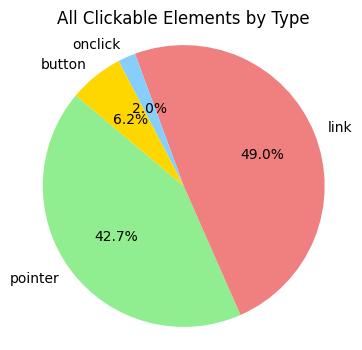

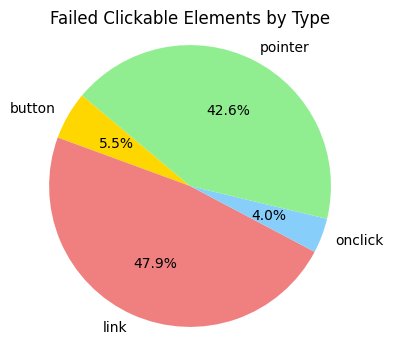

In [12]:
generate_pie_chart(click_types, title="All Clickable Elements by Type")
generate_pie_chart(click_failures, title="Failed Clickable Elements by Type")

Average clickstream length for each group.

- For baseline, this is the average length of the generated clickstream.
- For control and experimental, this is the average length of the successful traversal.

In [3]:
def count_actions(path: Path, name: str) -> int:
    """
    Counts the number of actions in a clickstream by counting the number of images in the directory.
    """    
    count = 0

    while True:
        if (path / f"{name}-{count+1}.png").is_file(): # We add 1 since the first image is the landing page (not an action)
            count += 1
        else:
            return count

def get_average_clickstream_length() -> pd.DataFrame:
    """
    Returns a dataframe with the average number of actions for each site.
    
    Should not be used to compute the average clickstream length for the entire crawl
    since we cannot take the average of averages.
    """    
    rows_list = []

    for domain in successful_sites:
        clickstreams = get_directories(site_results[domain]["data_path"])

        baseline_actions = 0
        controls_actions = 0
        experimental_actions = 0
        for clickstream in clickstreams:
            baseline_actions += count_actions(clickstream, "baseline")
            controls_actions += count_actions(clickstream, "control")
            experimental_actions += count_actions(clickstream, "experimental")

        rows_list.append({
            "domain": domain,
            "baseline_actions": baseline_actions / len(clickstreams),
            "control_actions": controls_actions / len(clickstreams),
            "experimental_actions": experimental_actions / len(clickstreams)
        })

    return pd.DataFrame(rows_list)

clickstream_lengths = get_average_clickstream_length()
clickstream_lengths


,domain,baseline_actions,control_actions,experimental_actions
0,twitter.com,5.000000,5.000000,5.000000
1,icloud.com,5.000000,5.000000,5.000000
2,googlevideo.com,5.000000,4.555556,3.111111
3,instagram.com,5.000000,5.000000,5.000000
4,doubleclick.net,5.000000,5.000000,5.000000
5,bing.com,5.000000,3.818182,3.727273
6,netflix.com,5.000000,4.400000,4.400000
7,cloudflare.com,5.000000,5.000000,5.000000
8,linkedin.com,5.000000,5.000000,5.000000
9,google.com,5.000000,3.909091,4.000000


In [4]:
def get_all_clickstream_lengths() -> tuple[list, list, list]:
    """
    Returns a tuple of lists containing the lengths of all clickstreams for each type.

    Returns: baseline_actions, controls_actions, experimental_actions
    """
    baseline_actions = []
    controls_actions = []
    experimental_actions = []
    for domain in successful_sites:
        clickstreams = get_directories(site_results[domain]["data_path"])

        for clickstream in clickstreams:
            baseline_actions.append(count_actions(clickstream, "baseline"))
            controls_actions.append(count_actions(clickstream, "control"))
            experimental_actions.append(count_actions(clickstream, "experimental"))
    
    return baseline_actions, controls_actions, experimental_actions

baseline_actions, controls_actions, experimental_actions = get_all_clickstream_lengths()
print(f"Average baseline length: {statistics.mean(baseline_actions)}")
print(f"Average control length: {statistics.mean(controls_actions)}")
print(f"Average experimental length: {statistics.mean(experimental_actions)}")

Average baseline length: 4.232558139534884
Average control length: 3.562015503875969
Average experimental length: 3.548449612403101


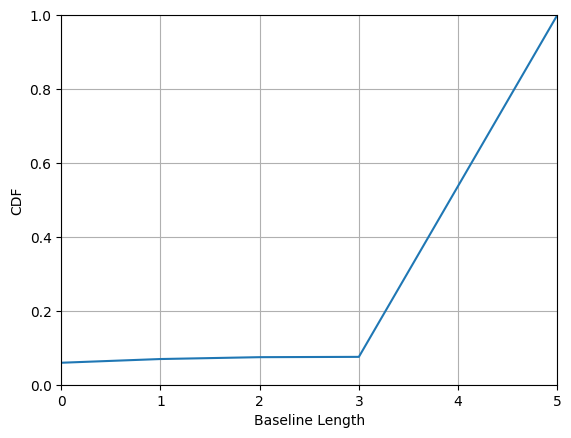

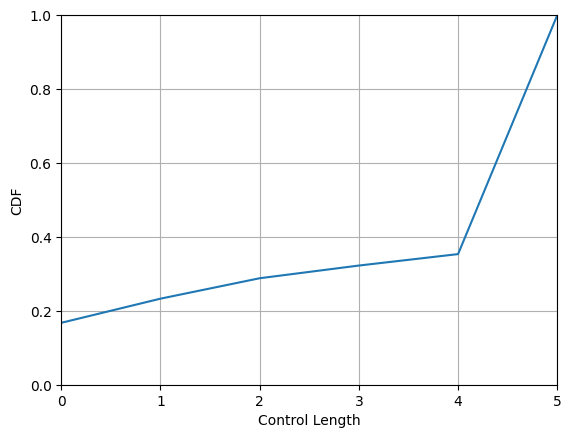

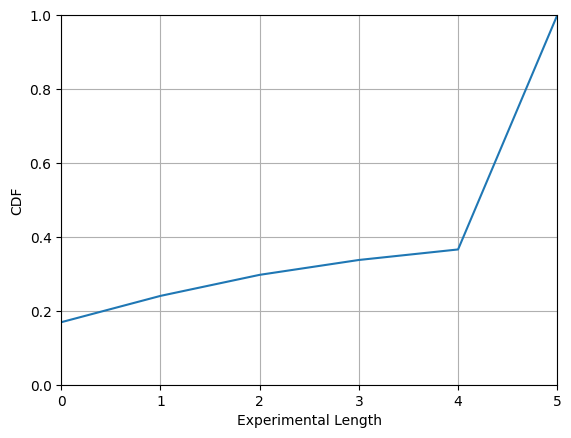

In [14]:
# plot_cdf(baseline_actions, "Baseline Length", [0, 5, 0, 1])
# plot_cdf(controls_actions, "Control Length", [0, 5, 0, 1])
# plot_cdf(experimental_actions, "Experimental Length", [0, 5, 0, 1])

In [15]:
print(len(baseline_actions))
print(len(controls_actions))
print(len(experimental_actions))

1194
1194
1194


## Analysis

In [16]:
def screenshot_comparison(sites: list) -> pd.DataFrame:
    results = []
    for i, domain in enumerate(sites):
        print(f"Analyzing site {i+1}/{len(successful_sites)}.")

        clickstreams = get_directories(site_results[domain]["data_path"])
        screenshot_sims = []
        for clickstream in clickstreams:
            for num_action in range(config["CLICKSTREAM_LENGTH"]+1):
                baseline_path = clickstream / f"baseline-{num_action}.png"
                control_path = clickstream / f"control-{num_action}.png"
                experimental_path = clickstream / f"experimental-{num_action}.png"
                
                if os.path.isfile(baseline_path) and os.path.isfile(control_path) and os.path.isfile(experimental_path):
                    CHUNK_SIZE = 40
                    baseline_shingle = ImageShingle(baseline_path, chunk_size = CHUNK_SIZE)
                    control_shingle = ImageShingle(control_path, chunk_size = CHUNK_SIZE)
                    experimental_shingle = ImageShingle(experimental_path, chunk_size = CHUNK_SIZE)

                    try:
                        screenshot_sims.append(ImageShingle.compare_with_control(baseline_shingle, control_shingle, experimental_shingle))
                    except ValueError as e:
                        print(e)

        if len(screenshot_sims) == 0:
            print(f"Skipping {domain} since no comparisons could be made.")
            continue

        screenshot_similarity = statistics.mean(screenshot_sims)
        sceenshot_difference = 1 - screenshot_similarity
        results.append({
            "domain": domain,
            "screenshot_difference": sceenshot_difference,
            f"samples": len(screenshot_sims),
        })

    return pd.DataFrame(results)

# screenshots = screenshot_comparison()
# screenshots.to_csv(ANALYSIS_PATH / "screenshots.csv", index=False)

In [2]:
df = pd.read_csv(ANALYSIS_PATH / 'screenshots.csv')
df.sort_values(by='screenshot_difference')

,domain,screenshot_difference,samples
66,goo.gl,0.000000,50
46,t.co,0.000000,54
95,googletagservices.com,0.000000,54
96,googleblog.com,0.000000,54
9,googleapis.com,0.000000,54
99,intuit.com,0.000000,20
102,mozilla.com,0.000000,51
50,whatsapp.com,0.000000,50
55,googledomains.com,0.000000,54
133,kaspersky.com,0.000000,54


## Screenshot Difference CDF

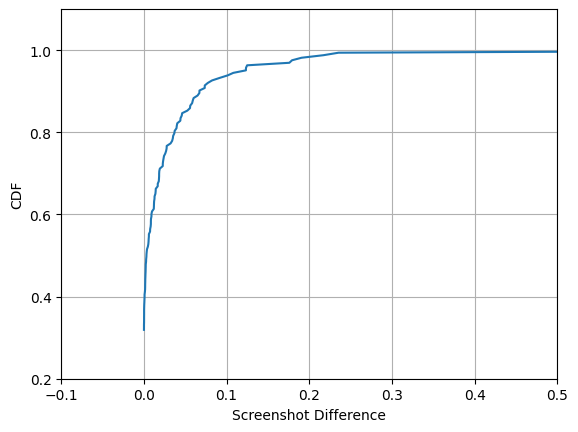

In [6]:
%matplotlib inline
plot_cdf(df['screenshot_difference'], 'Screenshot Difference', [-0.1, 0.5, 0.2, 1.1])

## Features Analysis

In [1]:
def jaccard_similarity(dict1, dict2):
    """
    Computes the Jaccard similarity between two frequency dictionaries.
    """    
    
    # Calculate the intersection of keys
    intersection_keys = set(dict1.keys()).intersection(set(dict2.keys()))
    intersection_sum = sum(min(dict1.get(k, 0), dict2.get(k, 0)) for k in intersection_keys)

    # Calculate the union of keys
    union_keys = set(dict1.keys()).union(set(dict2.keys()))
    union_sum = sum(max(dict1.get(k, 0), dict2.get(k, 0)) for k in union_keys)

    # Calculate Jaccard similarity
    if union_sum == 0:
        return 0  # to handle division by zero

    return intersection_sum / union_sum

In [2]:
def compare(list1: list[dict], list2: list[dict]):
    action_sims = []
    for dict1, dict2 in zip(list1, list2):
        action_sims.append(jaccard_similarity(dict1, dict2))

    return action_sims

In [9]:
def compare_features(feature: str, comparison: tuple[str, str]) -> pd.DataFrame:
    rows_list = []

    for i, domain in enumerate(successful_sites):
        print(f"Analyzing site {i+1}/{len(successful_sites)}.")
        clickstreams = get_directories(site_results[domain]["data_path"])

        all_action_sims = []
        for clickstream in clickstreams:
            data_path = clickstream / "features.json"
            
            # Skip if the file is missing
            if os.path.isfile(data_path) is False:
                continue
            
            with open(data_path) as data:
                data = json.load(data)
                
            # Skip if any of the data is missing
            if data[feature].get("baseline") is None or data[feature].get("control") is None or data[feature].get("experimental") is None:
                continue

            all_action_sims.extend(compare(data[feature][comparison[0]], data[feature][comparison[1]]))

        if len(all_action_sims) == 0:
            print(f"Skipping {domain} since no comparisons could be made.")
            continue

        website_similarity = statistics.mean(all_action_sims)
        website_difference = 1 - website_similarity

        website = os.path.basename(os.path.normpath(domain))
        rows_list.append({
            "website": website,
            f"mean diff": website_difference,
        })

    return pd.DataFrame(rows_list)

def merge_experiments(feature: str):
    A = compare_features(feature, ("baseline", "control"))
    B = compare_features(feature, ("baseline", "experimental"))
    diff = B["mean diff"] - A["mean diff"]

    df = pd.concat([A, B, diff], axis = 1, keys=(["control", "experimental", "difference in difference"]))
    df.name = feature
    return df

features: dict[str, None | pd.DataFrame] = {
    "innerText": None,
    "links": None,
    "img": None,
}
for feature in features:
    features[feature] = merge_experiments(feature)
    # results[feature].to_csv(f'analysis/{CRAWL_NAME}_{feature}.csv', index=False)


Analyzing site 1/166.
Analyzing site 2/166.
Analyzing site 3/166.
Analyzing site 4/166.
Analyzing site 5/166.
Analyzing site 6/166.
Analyzing site 7/166.
Analyzing site 8/166.
Analyzing site 9/166.
Analyzing site 10/166.
Analyzing site 11/166.
Analyzing site 12/166.
Analyzing site 13/166.
Analyzing site 14/166.
Analyzing site 15/166.
Analyzing site 16/166.
Analyzing site 17/166.
Analyzing site 18/166.
Analyzing site 19/166.
Analyzing site 20/166.
Analyzing site 21/166.
Analyzing site 22/166.
Analyzing site 23/166.
Analyzing site 24/166.
Analyzing site 25/166.
Analyzing site 26/166.
Analyzing site 27/166.
Analyzing site 28/166.
Analyzing site 29/166.
Analyzing site 30/166.
Analyzing site 31/166.
Analyzing site 32/166.
Analyzing site 33/166.
Analyzing site 34/166.
Analyzing site 35/166.
Analyzing site 36/166.
Analyzing site 37/166.
Analyzing site 38/166.
Analyzing site 39/166.
Analyzing site 40/166.
Analyzing site 41/166.
Analyzing site 42/166.
Skipping youtube.com since no comparisons c

In [10]:
features["innerText"]

control                       experimental            \
                     website mean diff                  website mean diff   
0                twitter.com  0.000000              twitter.com  0.000000   
1            googlevideo.com  0.000000          googlevideo.com  0.125122   
2                 icloud.com  0.000000               icloud.com  0.000000   
3            doubleclick.net  0.000000          doubleclick.net  0.000000   
4                netflix.com  0.038150              netflix.com  0.036307   
5               linkedin.com  0.062321             linkedin.com  0.026301   
6             cloudflare.com  0.000000           cloudflare.com  0.000000   
7                gstatic.com  0.000000              gstatic.com  0.000000   
8                 google.com  0.017117               google.com  0.030719   
9             googleapis.com  0.000000           googleapis.com  0.000000   
10             instagram.com  0.000508            instagram.com  0.000411   
11      googletagmanager.com  0.000000     googletagmanager.com  0.000000   
12                  bing.com  0.277461                 bing.com  0.350623   
13                  live.com  0.001400                 live.com  0.001522   
14                office.com  0.039322               office.com  0.035943   
15             pinterest.com  0.084363            pinterest.com  0.112985   
16     googlesyndication.com  0.000000    googlesyndication.com  0.023235   
17                 adobe.com  0.170518                adobe.com  0.128176   
18            cloudflare.net  0.007594           cloudflare.net  0.007795   
19                    ui.com  0.000000                   ui.com  0.000000   
20                github.com  0.007961               github.com  0.007945   
21      google-analytics.com  0.000000     google-analytics.com  0.000751   
22             wordpress.com  0.000195            wordpress.com  0.000201   
23                 gandi.net  0.020342                gandi.net  0.001641   
24              facebook.com  0.011255             facebook.com  0.010174   
25             amazonaws.com  0.011537            amazonaws.com  0.066410   
26              digicert.com  0.001289             digicert.com  0.001289   
27                 azure.com  0.014637                azure.com  0.022068   
28      googleadservices.com  0.000000     googleadservices.com  0.000000   
29                 apple.com  0.029404                apple.com  0.000762   
30                   ntp.org  0.000000                  ntp.org  0.000000   
31              whatsapp.net  0.000000             whatsapp.net  0.000000   
32               outlook.com  0.007180              outlook.com  0.001935   
33                 github.io  0.001043                github.io  0.003651   
34            sharepoint.com  0.037175           sharepoint.com  0.036228   
35                roblox.com  0.000000               roblox.com  0.000000   
36        cloudflare-dns.com  0.000000       cloudflare-dns.com  0.000000   
37                 vimeo.com  0.000000                vimeo.com  0.000000   
38             wikipedia.org  0.000074            wikipedia.org  0.016373   
39              blogspot.com  0.018519             blogspot.com  0.018519   
40                 yahoo.com  0.265833                yahoo.com  0.234558   
41              gravatar.com  0.000000             gravatar.com  0.000000   
42               comcast.net  0.042850              comcast.net  0.076494   
43     googleusercontent.com  0.000000    googleusercontent.com  0.000000   
44             wordpress.org  0.023107            wordpress.org  0.028805   
45               tiktokv.com  0.491423              tiktokv.com  0.491719   
46                      t.co  0.000000                     t.co  0.000000   
47                paypal.com  0.000556               paypal.com  0.000143   
48                   mail.ru  0.465616                  mail.ru  0.548630   
49                 lencr.org  0.009011                lencr.org  0.010102   
50              w

In [11]:
features["links"]

control                       experimental            \
                     website mean diff                  website mean diff   
0                twitter.com  0.019231              twitter.com  0.019231   
1            googlevideo.com  0.000000          googlevideo.com  0.128421   
2                 icloud.com  0.000000               icloud.com  0.000000   
3            doubleclick.net  0.010928          doubleclick.net  0.010928   
4                netflix.com  0.031145              netflix.com  0.031145   
5               linkedin.com  0.079203             linkedin.com  0.036693   
6             cloudflare.com  0.005554           cloudflare.com  0.019780   
7                gstatic.com  0.000000              gstatic.com  0.000000   
8                 google.com  0.019278               google.com  0.034221   
9             googleapis.com  0.000000           googleapis.com  0.000000   
10             instagram.com  0.244425            instagram.com  0.243079   
11      googletagmanager.com  0.000000     googletagmanager.com  0.000000   
12                  bing.com  0.715950                 bing.com  0.730846   
13                  live.com  0.013065                 live.com  0.006254   
14                office.com  0.055189               office.com  0.047215   
15             pinterest.com  0.083703            pinterest.com  0.129601   
16     googlesyndication.com  0.001610    googlesyndication.com  0.022727   
17                 adobe.com  0.229959                adobe.com  0.218491   
18            cloudflare.net  0.000000           cloudflare.net  0.000000   
19                    ui.com  0.000000                   ui.com  0.000000   
20                github.com  0.022206               github.com  0.024025   
21      google-analytics.com  0.001887     google-analytics.com  0.001887   
22             wordpress.com  0.000000            wordpress.com  0.000000   
23                 gandi.net  0.051594                gandi.net  0.045767   
24              facebook.com  0.133375             facebook.com  0.129068   
25             amazonaws.com  0.000314            amazonaws.com  0.066261   
26              digicert.com  0.000000             digicert.com  0.000000   
27                 azure.com  0.000720                azure.com  0.001086   
28      googleadservices.com  0.000000     googleadservices.com  0.000000   
29                 apple.com  0.024747                apple.com  0.001131   
30                   ntp.org  0.000000                  ntp.org  0.000000   
31              whatsapp.net  0.000000             whatsapp.net  0.000000   
32               outlook.com  0.010306              outlook.com  0.010063   
33                 github.io  0.001400                github.io  0.002272   
34            sharepoint.com  0.026216           sharepoint.com  0.025530   
35                roblox.com  0.000000               roblox.com  0.000000   
36        cloudflare-dns.com  0.000000       cloudflare-dns.com  0.000000   
37                 vimeo.com  0.027200                vimeo.com  0.027200   
38             wikipedia.org  0.000249            wikipedia.org  0.018264   
39              blogspot.com  0.017958             blogspot.com  0.017958   
40                 yahoo.com  0.344862                yahoo.com  0.221879   
41              gravatar.com  0.000000             gravatar.com  0.000000   
42               comcast.net  0.036549              comcast.net  0.074531   
43     googleusercontent.com  0.000000    googleusercontent.com  0.000000   
44             wordpress.org  0.014748            wordpress.org  0.023984   
45               tiktokv.com  0.508578              tiktokv.com  0.508578   
46                      t.co  0.000000                     t.co  0.000000   
47                paypal.com  0.000523               paypal.com  0.000159   
48                   mail.ru  0.745098                  mail.ru  0.743421   
49                 lencr.org  0.014750                lencr.org  0.014750   
50              w

In [24]:
features["img"]

control                               experimental  \
                   website mean diff     stdev                website   
0               icloud.com  0.757202  0.063369             icloud.com   
1              netflix.com  0.018868  0.059020            netflix.com   
2              twitter.com  1.000000  0.000000            twitter.com   
3               github.com  0.234183  0.388529             github.com   
4              gstatic.com  1.000000  0.000000            gstatic.com   
5     googletagmanager.com  1.000000  0.000000   googletagmanager.com   
6           googleapis.com  1.000000  0.000000         googleapis.com   
7            pinterest.com  0.380640  0.415313          pinterest.com   
8               google.com  0.019794  0.139963             google.com   
9                apple.com  0.385396  0.486460              apple.com   
10           instagram.com  0.000000  0.000000          instagram.com   
11            facebook.com  0.003704  0.027217           facebook.com   
12           amazonaws.com  0.012414  0.030243          amazonaws.com   
13               adobe.com  0.348440  0.307581              adobe.com   
14                live.com  0.078501  0.048519               live.com   
15             youtube.com  0.302882  0.191118            youtube.com   
16                bing.com  0.308070  0.272860               bing.com   
17                youtu.be  0.334147  0.227070               youtu.be   
18                  ui.com  0.004871  0.018177                 ui.com   
19               azure.com  0.008399  0.002952              azure.com   
20    googleadservices.com  1.000000  0.000000   googleadservices.com   
21           wikipedia.org  0.000000  0.000000          wikipedia.org   
22           wordpress.com  0.396198  0.405142          wordpress.com   
23   googleusercontent.com  1.000000  0.000000  googleusercontent.com   
24          cloudflare.net  0.664198  0.367885         cloudflare.net   
25             tiktokv.com  0.470466  0.256432            tiktokv.com   
26   googlesyndication.com  0.037736  0.192380  googlesyndication.com   
27            whatsapp.net  0.044974  0.191912           whatsapp.net   
28               gandi.net  0.206667  0.403443              gandi.net   
29                 ntp.org  0.006410  0.046225                ntp.org   
30             outlook.com  0.123469  0.196343            outlook.com   
31            whatsapp.com  0.056463  0.191991           whatsapp.com   
32               vimeo.com  0.109077  0.297819              vimeo.com   
33    google-analytics.com  0.000000  0.000000   google-analytics.com   
34                  bit.ly  0.044444  0.156226                 bit.ly   
35              fastly.net  0.539435  0.221682             fastly.net   
36             mozilla.org  0.000000  0.000000            mozilla.org   
37                 zoom.us  0.204866  0.229053                zoom.us   
38               github.io  0.329705  0.465316              github.io   
39               yandex.ru  0.714535  0.158388              yandex.ru   
40           office365.com  0.094916  0.180279          office365.com   
41                pki.goog  0.160000  0.370328               pki.goog   
42                    t.co  0.000000  0.000000                   t.co   
43              tiktok.com  0.471618  0.280240             tiktok.com   
44              roblox.com  0.000000  0.000000             roblox.com   
45              paypal.com  0.050658  0.202454             paypal.com   
46              meraki.com  0.095905  0.124374             meraki.com   
47           wordpress.org  0.195444  0.161019          wordpress.org   
48                  goo.gl  0.000000  0.000000                 goo.gl   
49              flickr.com  0.839882  0.370277             flickr.com   
50              amazon.com  0.369272  0.386016             amazon.com   
51               baidu.com  0.026455  0.043058              baidu.com   
52            gravatar.com  0.800389  0.314853           gravatar.com   
53  

In [12]:
# Difference Baseline / Experimental
plot_cdf(list(features["innerText"]["experimental"]["mean diff"]), "innerText", [-0.1, 1, 0.2, 1.1])
plot_cdf(list(features["links"]["experimental"]["mean diff"]), "links", [-0.1, 1, 0.2, 1.1])
plot_cdf(list(features["img"]["experimental"]["mean diff"]), "img", [-0.1, 1, 0.2, 1.1])

NameError: name 'plot_cdf' is not defined

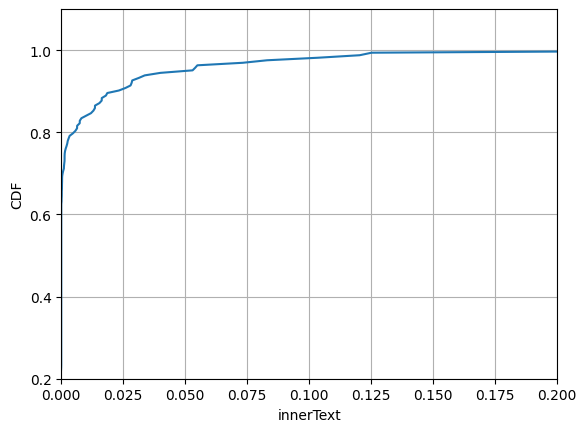

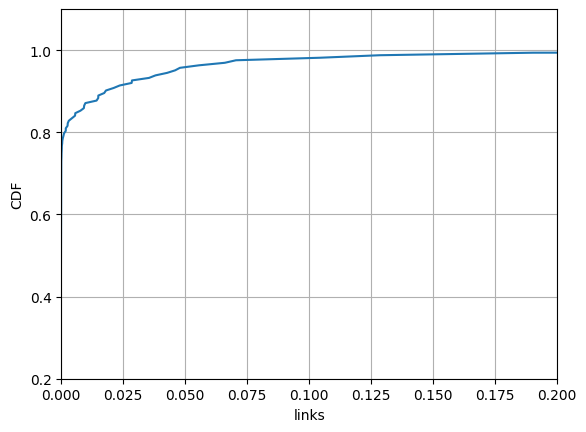

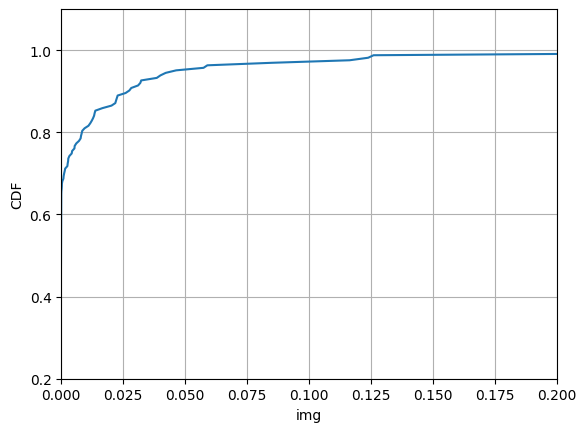

In [14]:
# Difference of Difference
plot_cdf(list(features["innerText"]["difference in difference"]["mean diff"]), "innerText", [0, 0.2, 0.2, 1.1])
plot_cdf(list(features["links"]["difference in difference"]["mean diff"]), "links", [0, 0.2, 0.2, 1.1])
plot_cdf(list(features["img"]["difference in difference"]["mean diff"]), "img", [0, 0.2, 0.2, 1.1])

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_comparison(df: pd.DataFrame, title: str):
    # Set the x-axis labels to be the websites
    websites = df["control"]["website"]
    x = np.arange(len(websites))  # Use numpy.arange for better control

    # Set the data for the second CSV (remove-third-party)
    mean_diff_control = df["control"]["mean diff"]
    stdev_control = df["control"]["stdev"]

    # Set the data for the first CSV (remove-all)
    mean_diff_experimental = df["experimental"]["mean diff"]
    stdev_experimental = df["experimental"]["stdev"]

    # Create the figure and axes for the plot
    _, ax = plt.subplots(figsize=(12, 6))

    # Define a color for the bars and error bars
    bar_color = "skyblue"

    # Width of the bars
    width = 0.35

    # Bars
    bars1 = ax.bar(x - width/2, mean_diff_control, width=width, label="Control", color="lightcoral", alpha=0.7)
    bars2 = ax.bar(x + width/2, mean_diff_experimental, width=width, label="Experimental", color=bar_color, alpha=0.7)

    # Set the x-axis labels
    ax.set_xticks(x)
    ax.set_xticklabels(websites, rotation=90)

    # Set labels and title
    ax.set_xlabel("Website")
    ax.set_ylabel("Mean Difference")
    ax.set_title(f"{title} feature comparison (10 clickstreams, length 5)")

    # Add a legend
    ax.legend()

    # Customize the error bars to match the bar color and add horizontal lines
    # error_kw = {'capsize': 5, 'ecolor': 'lightcoral', 'color': 'lightcoral'}
    # ax.bar(x - width/2, mean_diff_control, width=width, yerr=stdev_control, alpha=0, error_kw=error_kw)
    
    # error_kw = {'capsize': 5, 'ecolor': bar_color, 'color': bar_color}
    # ax.bar(x + width/2, mean_diff_experimental, width=width, yerr=stdev_experimental, alpha=0, error_kw=error_kw)

    # Add text labels for the values at the top of each bar
    for bar1, bar2 in zip(bars1, bars2):
        height1 = bar1.get_height()
        height2 = bar2.get_height()
        ax.annotate(f"{height1:.2f}", (bar1.get_x() + bar1.get_width() / 2, height1),
                    ha="center", va="bottom", fontsize=8)
        ax.annotate(f"{height2:.2f}", (bar2.get_x() + bar2.get_width() / 2, height2),
                    ha="center", va="bottom", fontsize=8)

    # Show the plot
    plt.tight_layout()
    plt.show()

for feature in site_results:
    plot_comparison(site_results[feature], feature)